In [39]:
'''
Implmemtation of qiskit Variational Quantum Classifier
Reference:https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02_neural_network_classifier_and_regressor.html
'''
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42



In [40]:
#load adjacency matrix
A = np.load(file="adj.coo.npy")
adj_matrix = np.zeros((2708,2708))
#print(len(A))
for i in range(2708):
    a = int(A[0][i])
    b = int(A[1][i])
    #print(a)
    #print(b)
    adj_matrix[a][b] = 1
    adj_matrix[b][a] = 1


In [41]:
#load label
y = np.load(file="y_label.npy")

print(y)
print(y.shape)

[3 4 4 ... 3 3 3]
(2708,)


In [42]:
#load feature
feature = np.load(file="feature.npy")
print(len(feature))
print([len(a) for a in feature])

2708
[1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433

In [43]:
feature_num = np.zeros(1433)
for i in range(1433):
    feature_num[i] = np.count_nonzero(feature[:,i])
print(feature_num)
index = np.argsort(feature_num)
index = index[::-1]
print(index)
feature = feature[:,index]
for i in range(1433):
    feature_num[i] = np.count_nonzero(feature[:,i])
print(feature_num)

[16. 33. 70. ...  6. 65. 12.]
[1177 1263  507 ... 1000  657  444]
[1.083e+03 9.800e+02 6.760e+02 ... 1.000e+00 1.000e+00 0.000e+00]


In [44]:
# N: number of nodes, d:number of feature
def get_data(N,d):
    #adj = np.asarray(np.load(file="adj.coo.npy"))
    adj = adj_matrix
    y = np.asarray(np.load(file="y_label.npy"))
    feature_all = np.asarray(np.load(file="feature.npy"))

    feature_num = np.zeros(1433)
    for i in range(1433):
        feature_num[i] = np.count_nonzero(feature_all[:,i])
    #print(feature_num)
    index = np.argsort(feature_num)
    index = index[::-1]
    #print(index)
    feature_all = feature_all[:,index]
    
    
    
    count = 0
    feature = np.zeros((N,d))
    remove = []
    count_5 = 0
    count_6 = 0
    while(count != N):
        print(count)
        print(feature_all.shape)
        L2_norm = np.linalg.norm(feature_all[count,0:d],2)
#L2_norm != 0 and 
        if L2_norm != 0 and (y[count] == 5 or y[count] == 6): # load the node with label 5 or 6 and its feature is non-zero
            if y[count] == 5 and count_5 < N/2:
                count_5 = count_5 + 1
                feature[count,0:d] = feature_all[count,0:d] / L2_norm
                count = count + 1
            elif y[count] == 6 and count_6 < N/2:
                count_6 = count_6 + 1
                feature[count,0:d] = feature_all[count,0:d] / L2_norm
                count = count + 1
            else:
                remove.append(count)
                #print(count)
                y = np.delete(y,count)
                adj = np.delete(adj,count,0)
                adj = np.delete(adj,count,1)
                feature_all = np.delete(feature_all,count,0)

            
        else:
            remove.append(count)
            #print(count)
            y = np.delete(y,count)
            adj = np.delete(adj,count,0)
            adj = np.delete(adj,count,1)
            feature_all = np.delete(feature_all,count,0)
            #print(feature_all.shape)
    adj = adj[0:N,0:N]
    
    feature = feature[0:N,0:d]
    #print(feature.shape)
    y = y[0:N]
    #print(remove)
    #print(count)
    print(adj.shape)
    print(feature.shape)
    print(y.shape)
    return adj, feature, y

In [45]:
# N: number of nodes, d:number of feature
N = 32

d = 8
adj, feature, label = get_data(N,d)


0
(2708, 1433)
0
(2707, 1433)
0
(2706, 1433)
0
(2705, 1433)
0
(2704, 1433)
0
(2703, 1433)
0
(2702, 1433)
0
(2701, 1433)
0
(2700, 1433)
0
(2699, 1433)
0
(2698, 1433)
0
(2697, 1433)
0
(2696, 1433)
0
(2695, 1433)
0
(2694, 1433)
0
(2693, 1433)
0
(2692, 1433)
0
(2691, 1433)
0
(2690, 1433)
0
(2689, 1433)
0
(2688, 1433)
0
(2687, 1433)
0
(2686, 1433)
0
(2685, 1433)
1
(2685, 1433)
1
(2684, 1433)
1
(2683, 1433)
2
(2683, 1433)
2
(2682, 1433)
2
(2681, 1433)
2
(2680, 1433)
2
(2679, 1433)
3
(2679, 1433)
3
(2678, 1433)
3
(2677, 1433)
3
(2676, 1433)
3
(2675, 1433)
3
(2674, 1433)
4
(2674, 1433)
4
(2673, 1433)
4
(2672, 1433)
4
(2671, 1433)
5
(2671, 1433)
6
(2671, 1433)
6
(2670, 1433)
6
(2669, 1433)
6
(2668, 1433)
6
(2667, 1433)
7
(2667, 1433)
7
(2666, 1433)
7
(2665, 1433)
8
(2665, 1433)
8
(2664, 1433)
8
(2663, 1433)
8
(2662, 1433)
8
(2661, 1433)
8
(2660, 1433)
9
(2660, 1433)
9
(2659, 1433)
9
(2658, 1433)
9
(2657, 1433)
9
(2656, 1433)
9
(2655, 1433)
9
(2654, 1433)
9
(2653, 1433)
9
(2652, 1433)
9
(2651, 1

In [46]:
#print the max dimension of feature among the nodes
count = 0
for i in range(N):
    temp = np.count_nonzero(feature[i,:])
    if temp > count:
        count = temp
print(count)

5


In [52]:
np.save("feature_temp", feature)

In [47]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [53]:
vqc = VQC(
    num_qubits=d,
    optimizer=COBYLA(maxiter=150),
    callback=callback_graph,
)

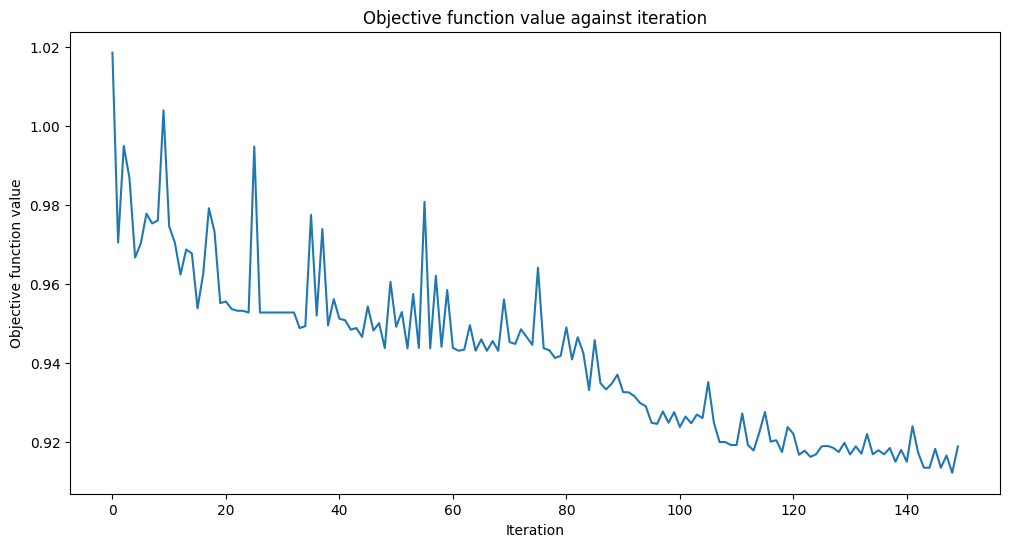

0.71875

In [54]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(feature, label)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(feature, label)

In [55]:
predict = vqc.predict(feature)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {label}")

Predicted labels: [6 6 6 5 6 6 5 5 6 6 5 5 5 6 6 5 6 6 5 5 5 5 6 6 6 6 6 5 6 6 6 5]
Ground truth:     [6 6 6 5 6 6 5 5 6 6 5 5 6 6 6 5 5 5 5 5 6 5 6 5 5 6 5 5 5 6 6 6]


In [56]:
a = np.array([[1,0,0],[0,1,0],[0,0,1]])
index = [2 ,0, 1]
a = a[:,index]
print(a)

[[0 1 0]
 [0 0 1]
 [1 0 0]]
